<a href="https://colab.research.google.com/github/datacentertugaskuliah-coder/PraktikumDS/blob/main/Reduksi_Dimensi_dengan_PCA_dan_Validasi_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

replace UCI HAR Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: Ukuran X_train: (7352, 561) | Ukuran y_train: (7352,)
Ukuran X_test : (2947, 561) | Ukuran y_test : (2947,)


,train_count,test_count
0,,
1 - WALKING,1226,496
2 - WALKING_UPSTAIRS,1073,471
3 - WALKING_DOWNSTAIRS,986,420
4 - SITTING,1286,491
5 - STANDING,1374,532
6 - LAYING,1407,537


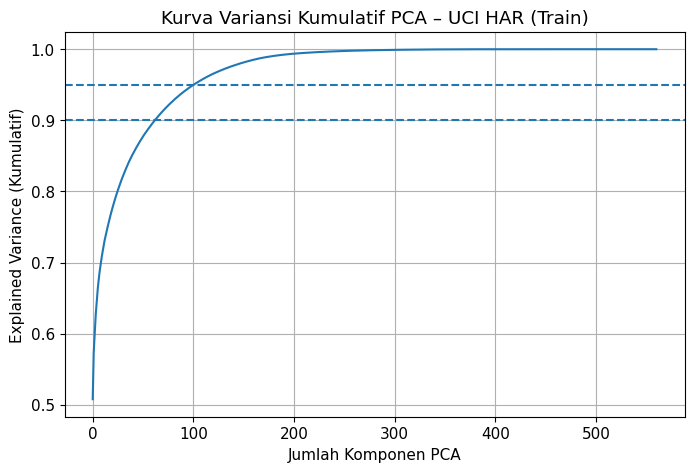

Komponen untuk ~90% variansi : 63
Komponen untuk ~95% variansi : 102
Dimensi sebelum PCA : 561 fitur
Dimensi setelah PCA : 102 komponen


,PC,Variance_Ratio,Cumulative
0,PC1,0.507812,0.507812
1,PC2,0.065807,0.573619
2,PC3,0.028064,0.601683
3,PC4,0.025040,0.626722
4,PC5,0.018883,0.645605
5,PC6,0.017240,0.662845
6,PC7,0.013710,0.676555
7,PC8,0.011991,0.688546
8,PC9,0.009959,0.698505
9,PC10,0.009651,0.708156


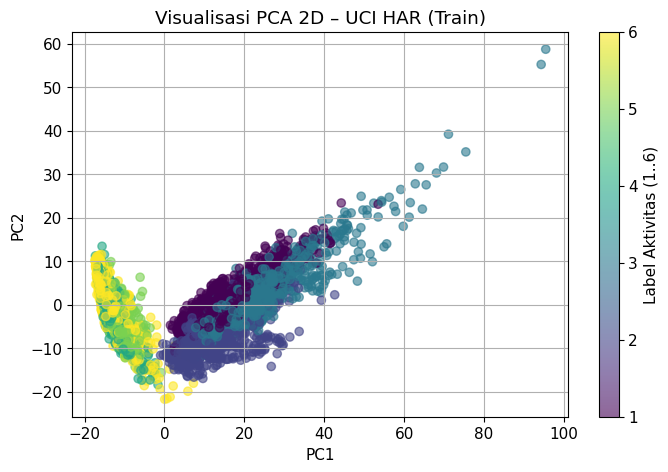

Akurasi Logistic Regression (Test): 0.9314557176789956

Classification Report - Logistic Regression:

                    precision    recall  f1-score   support

           WALKING       0.93      0.98      0.95       496
  WALKING_UPSTAIRS       0.91      0.90      0.91       471
WALKING_DOWNSTAIRS       0.94      0.90      0.92       420
           SITTING       0.92      0.87      0.89       491
          STANDING       0.88      0.93      0.91       532
            LAYING       1.00      0.99      1.00       537

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



<Figure size 900x700 with 0 Axes>

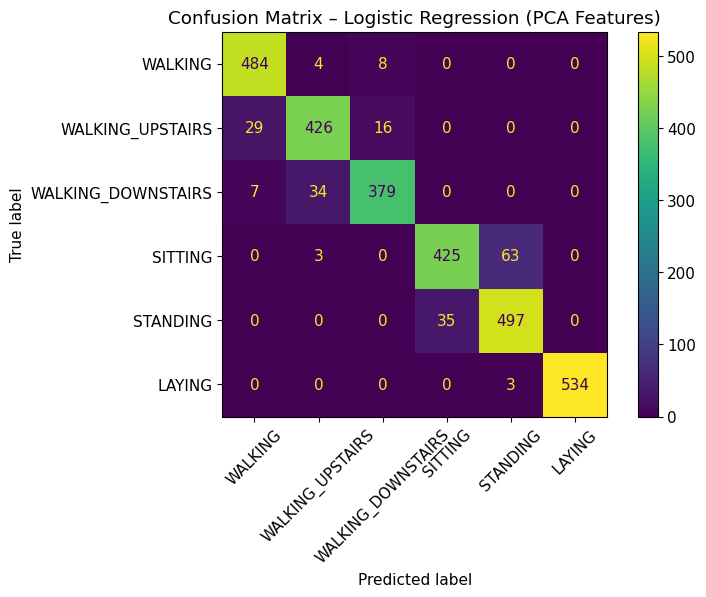

Akurasi Linear SVM (Test): 0.9304377332880895

Classification Report - Linear SVM:

                    precision    recall  f1-score   support

           WALKING       0.90      0.98      0.94       496
  WALKING_UPSTAIRS       0.94      0.88      0.91       471
WALKING_DOWNSTAIRS       0.96      0.91      0.94       420
           SITTING       0.92      0.87      0.89       491
          STANDING       0.89      0.93      0.91       532
            LAYING       0.98      1.00      0.99       537

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



<Figure size 900x700 with 0 Axes>

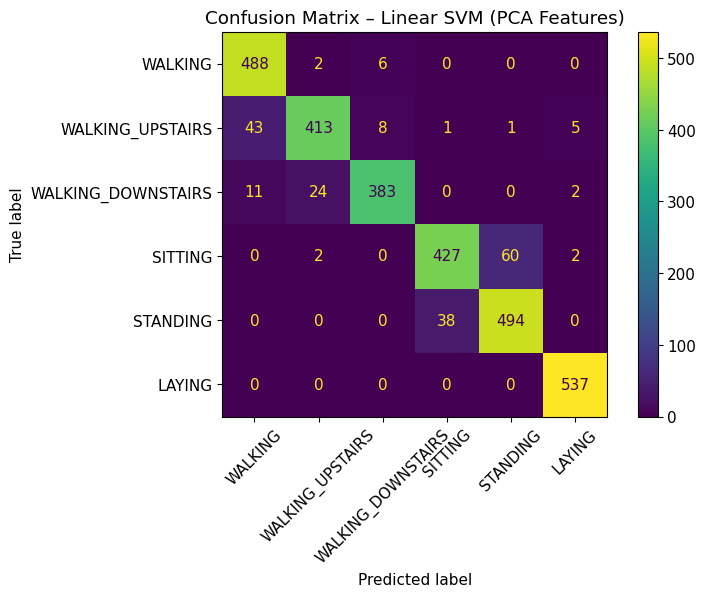

,Model,Akurasi Test,Karakteristik
0,Logistic Regression,0.931456,"Baseline, cepat, interpretatif"
1,Linear SVM,0.930438,"Margin-based, robust pada fitur PCA"


,Aspek,Keterangan
0,Sumber dataset,UCI HAR (train/test resmi)
1,Jumlah fitur awal,561 fitur
2,Target variansi PCA,95%
3,Jumlah komponen terpilih,102 komponen
4,Model baseline,Logistic Regression
5,Akurasi baseline (test),0.9315
6,Model validasi,Linear SVM
7,Akurasi validasi (test),0.9304



Catatan:
- Standardisasi menjaga kontribusi setiap fitur seimbang.
- PCA merangkum 561 fitur menjadi komponen yang memuat informasi utama.
- Visualisasi 2D dipakai untuk membaca pola global, bukan untuk penilaian akhir.
- Perbandingan Logistic Regression vs Linear SVM memvalidasi bahwa fitur PCA bersifat stabil.
- Confusion matrix membantu melihat aktivitas mana yang paling sering tertukar.



In [3]:
# ==========================================================
# Praktikum Data Science dan Machine Learning Berbasis Python dan UCI Repository
# Pertemuan: 9 – Reduksi Dimensi dengan PCA dan Validasi Model (Perbandingan Baseline)
# Dataset: Human Activity Recognition Using Smartphones (HAR) (UCI Machine Learning Repository)
# Repo: https://github.com/datacentertugaskuliah-coder/PraktikumDS.git
# Lingkungan: Google Colab
# ==========================================================

# ==========================================================
# 0) SETUP
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 11

# ==========================================================
# 1) AKUISISI DATA (UCI HAR) + EKSTRAK
#    Catatan integritas: dataset resmi berformat zip, sudah terpisah train/test
# ==========================================================
UCI_ZIP_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
ZIP_NAME = "UCI_HAR_Dataset.zip"

!wget -q -O "$ZIP_NAME" "$UCI_ZIP_URL"
!unzip -q "$ZIP_NAME"

base_path = "UCI HAR Dataset"

# ==========================================================
# 2) PEMUATAN DATA (TRAIN/TEST) + LABEL MAP + RINGKASAN AWAL
#    Revisi: ganti delim_whitespace=True menjadi sep=r"\\s+" agar future-proof
# ==========================================================
X_train = pd.read_csv(f"{base_path}/train/X_train.txt", sep=r"\s+", header=None)
y_train = pd.read_csv(f"{base_path}/train/y_train.txt", header=None).iloc[:, 0]

X_test  = pd.read_csv(f"{base_path}/test/X_test.txt", sep=r"\s+", header=None)
y_test  = pd.read_csv(f"{base_path}/test/y_test.txt", header=None).iloc[:, 0]

activity_map = pd.read_csv(
    f"{base_path}/activity_labels.txt",
    sep=r"\s+",
    header=None,
    names=["id", "activity"]
)
id_to_activity = dict(zip(activity_map["id"], activity_map["activity"]))
target_names = [id_to_activity[i] for i in sorted(id_to_activity.keys())]

print("Ukuran X_train:", X_train.shape, "| Ukuran y_train:", y_train.shape)
print("Ukuran X_test :", X_test.shape,  "| Ukuran y_test :", y_test.shape)

# Tabel distribusi label (train & test)
dist_train = y_train.value_counts().sort_index().rename("train_count")
dist_test  = y_test.value_counts().sort_index().rename("test_count")
dist_table = pd.concat([dist_train, dist_test], axis=1)
dist_table.index = dist_table.index.map(lambda i: f"{i} - {id_to_activity.get(i,'')}")
display(dist_table)

# ==========================================================
# 3) PRAPEMROSESAN: STANDARDISASI
#    Alasan: PCA berbasis varians sehingga skala fitur perlu diseragamkan
# ==========================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ==========================================================
# 4) PCA ANALISIS: EXPLAINED VARIANCE (KUMULATIF)
#    Tujuan: memilih n_components yang menjaga informasi utama
# ==========================================================
pca_probe = PCA(random_state=42)
pca_probe.fit(X_train_scaled)

cum_var = np.cumsum(pca_probe.explained_variance_ratio_)

plt.figure()
plt.plot(cum_var)
plt.axhline(0.90, linestyle="--")
plt.axhline(0.95, linestyle="--")
plt.xlabel("Jumlah Komponen PCA")
plt.ylabel("Explained Variance (Kumulatif)")
plt.title("Kurva Variansi Kumulatif PCA – UCI HAR (Train)")
plt.grid(True)
plt.show()

target_var = 0.95
n_components_95 = int(np.searchsorted(cum_var, target_var) + 1)

print("Komponen untuk ~90% variansi :", int(np.searchsorted(cum_var, 0.90) + 1))
print("Komponen untuk ~95% variansi :", n_components_95)

# ==========================================================
# 5) TRANSFORMASI PCA (REDUKSI DIMENSI) UNTUK PEMODELAN
# ==========================================================
pca = PCA(n_components=n_components_95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Dimensi sebelum PCA :", X_train.shape[1], "fitur")
print("Dimensi setelah PCA :", X_train_pca.shape[1], "komponen")

# Tabel ringkas variansi beberapa komponen awal
var_ratio = pd.Series(pca.explained_variance_ratio_, name="variance_ratio")
var_table = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(min(10, len(var_ratio)))],
    "Variance_Ratio": var_ratio.iloc[:10].values,
    "Cumulative": np.cumsum(var_ratio.iloc[:10].values)
})
display(var_table)

# ==========================================================
# 6) VISUALISASI PCA 2D (UNTUK PEMAHAMAN POLA)
#    Reduksi ke 2D hanya untuk plot, bukan untuk model utama
# ==========================================================
pca_2d = PCA(n_components=2, random_state=42)
X_train_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure()
scatter = plt.scatter(
    X_train_2d[:, 0],
    X_train_2d[:, 1],
    c=y_train,
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Visualisasi PCA 2D – UCI HAR (Train)")
cbar = plt.colorbar(scatter)
cbar.set_label("Label Aktivitas (1..6)")
plt.grid(True)
plt.show()

# ==========================================================
# 7A) MODEL 1: LOGISTIC REGRESSION (BASELINE) DI RUANG PCA
# ==========================================================
lr_clf = LogisticRegression(max_iter=3000, n_jobs=None)
lr_clf.fit(X_train_pca, y_train)

y_pred_lr = lr_clf.predict(X_test_pca)
acc_lr = accuracy_score(y_test, y_pred_lr)

print("Akurasi Logistic Regression (Test):", acc_lr)
print("\nClassification Report - Logistic Regression:\n")
print(classification_report(y_test, y_pred_lr, target_names=target_names))

# Confusion matrix Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=sorted(id_to_activity.keys()))
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=target_names)

plt.figure(figsize=(9, 7))
disp_lr.plot(xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix – Logistic Regression (PCA Features)")
plt.show()

# ==========================================================
# 7B) MODEL 2: LINEAR SVM (VALIDASI TAMBAHAN) DI RUANG PCA
# ==========================================================
svm_clf = LinearSVC(max_iter=5000)
svm_clf.fit(X_train_pca, y_train)

y_pred_svm = svm_clf.predict(X_test_pca)
acc_svm = accuracy_score(y_test, y_pred_svm)

print("Akurasi Linear SVM (Test):", acc_svm)
print("\nClassification Report - Linear SVM:\n")
print(classification_report(y_test, y_pred_svm, target_names=target_names))

# Confusion matrix Linear SVM
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=sorted(id_to_activity.keys()))
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=target_names)

plt.figure(figsize=(9, 7))
disp_svm.plot(xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix – Linear SVM (PCA Features)")
plt.show()

# ==========================================================
# 8) TABEL PERBANDINGAN MODEL
# ==========================================================
comparison = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Linear SVM"
    ],
    "Akurasi Test": [
        acc_lr,
        acc_svm
    ],
    "Karakteristik": [
        "Baseline, cepat, interpretatif",
        "Margin-based, robust pada fitur PCA"
    ]
})
display(comparison)

# ==========================================================
# 9) RINGKASAN EKSPERIMEN (TABEL)
# ==========================================================
summary = pd.DataFrame({
    "Aspek": [
        "Sumber dataset",
        "Jumlah fitur awal",
        "Target variansi PCA",
        "Jumlah komponen terpilih",
        "Model baseline",
        "Akurasi baseline (test)",
        "Model validasi",
        "Akurasi validasi (test)"
    ],
    "Keterangan": [
        "UCI HAR (train/test resmi)",
        f"{X_train.shape[1]} fitur",
        f"{int(target_var*100)}%",
        f"{n_components_95} komponen",
        "Logistic Regression",
        f"{acc_lr:.4f}",
        "Linear SVM",
        f"{acc_svm:.4f}"
    ]
})
display(summary)

# ==========================================================
# 10) CATATAN PRAKTIK (OUTPUT TEKS)
# ==========================================================
print(
    "\nCatatan:\n"
    "- Standardisasi menjaga kontribusi setiap fitur seimbang.\n"
    "- PCA merangkum 561 fitur menjadi komponen yang memuat informasi utama.\n"
    "- Visualisasi 2D dipakai untuk membaca pola global, bukan untuk penilaian akhir.\n"
    "- Perbandingan Logistic Regression vs Linear SVM memvalidasi bahwa fitur PCA bersifat stabil.\n"
    "- Confusion matrix membantu melihat aktivitas mana yang paling sering tertukar.\n"
)
